In [18]:
import sys
import time
import aubio
import mido
from mido import Message, MetaMessage, MidiFile, MidiTrack, second2tick, bpm2tempo
from pathlib import Path
from aubio import miditofreq
import numpy as np
from numpy import arange
import math
from matplotlib import pyplot as plt

In [3]:
root = Path("/home/livingston/dev/drl/realtime-audio-rs/examples")
WAV_C_MAJOR = str(root / "data" / "C_major.wav")
WAV_GUITAR = str(root / "data" / "guitar_c4_scale.wav")
WAV_PIANO  = str(root / "data" / "c3-major-scale-piano.wav")

In [4]:
def gen_freqs(filename: str, min_confidence = 0.3):
    downsample = 1

    win_s = 512 // downsample # fft size
    hop_s = 256 // downsample # hop size

    with aubio.source(filename, hop_size=hop_s) as source:
        print(f"""{filename}
    ------------------------
    URI: {source.uri}
    Sample Rate: {source.samplerate}
    Duration: {source.duration}
    Channels: {source.channels}
        """)
        samplerate = source.samplerate

        # --- Begin Analysis -------------------------------------- #
        pitch_o = aubio.pitch("default",
                              buf_size=win_s,
                              hop_size=hop_s,
                              samplerate=samplerate)

        notes_o = aubio.notes("default",
                              buf_size=win_s,
                              hop_size=hop_s,
                              samplerate=samplerate)

        # --- Read samples from file ------------------------------------- #
        _return = {
            "metadata": {
                "name": Path(source.uri).stem,
                "samplerate": samplerate,
                "num_samples": 0,
                "buf_size": win_s,
                "hop_size": hop_s,
                "channels": source.channels,
                "duration": source.duration
            },
            "pitch": [],
            "notes": []
        }

        i = 0
        total_frames = 0
        while True:
            samples, read = source()
            total_frames += read
            if read < hop_s:
                break

            time = i * hop_s

            pitch = pitch_o(samples)
            confidence = pitch_o.get_confidence()

            if (confidence > min_confidence):
                _return["pitch"].append(
                    ( time, pitch[0] )
                )

            note = notes_o(samples)

            if (note[0] != 0): # valid note found
                _return["notes"].append(
                    ( time, miditofreq(note[0]) )
                )

            i += 1

    return _return

In [5]:
def plot_data(data: dict):
    from matplotlib import pyplot as plt
    import numpy as np

    ax = plt.axes()

    pitch = np.array(data["pitch"])
    notes = np.array(data["notes"])

    print(f"Data shape: {pitch.shape=}; {notes.shape=}")
    
    ax.semilogy(pitch[:,0], pitch[:,1], '.')
    ax.semilogy(notes[:,0], notes[:,1], '.')

    for note in notes:
        t, n = note
        ax.annotate(freq_to_note(n), (t, n))

    #ax.set_xlim(0, data["metadata"]["duration"])
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency [Hz]")
    ax.grid(True)

    ax.set_title(data["metadata"]["name"])
    ax.set_title("channels: {}\nduration: {}\nsamplerate: {}".format(
            data["metadata"]["channels"],
            data["metadata"]["duration"],
            data["metadata"]["samplerate"]
        ), loc='left')
    ax.set_title("samples: {}\nhop size: {}\nbuff size: {}".format(
            data["metadata"]["num_samples"],
            data["metadata"]["hop_size"],
            data["metadata"]["buf_size"]
        ), loc='right')

    plt.show()

In [6]:
def freq_to_note(freq):
    notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

    if freq == 0.:
        return "", 0

    note_number = 12 * math.log2(freq / 440) + 49
    note_number = round(note_number)

    note = (note_number - 1 ) % len(notes)
    note = notes[note]

    octave = (note_number + 8 ) // len(notes)

    return note, octave


/home/livingston/dev/drl/realtime-audio-rs/examples/data/C_major.wav
    ------------------------
    URI: /home/livingston/dev/drl/realtime-audio-rs/examples/data/C_major.wav
    Sample Rate: 44100
    Duration: 444096
    Channels: 1
        
Data shape: pitch.shape=(2, 2); notes.shape=(26, 2)


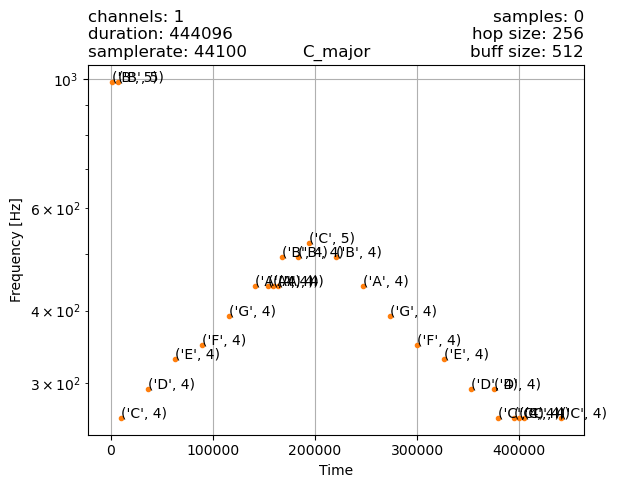

In [7]:
data = gen_freqs(WAV_C_MAJOR)
plot_data(data)

duration: 10.070204 seconds (444096 samples)
0.012 (512,) 0.0
0.023 (512,) 0.6305059194564819
0.035 (512,) 0.49528783559799194
0.046 (512,) 0.4199044108390808
0.058 (512,) 0.09616029262542725
0.070 (512,) 0.31215983629226685
0.081 (512,) 0.2787439227104187
0.093 (512,) 0.051624298095703125
0.104 (512,) 0.20624011754989624
0.116 (512,) 0.23842203617095947
0.128 (512,) 0.29100966453552246
0.139 (512,) 0.6071971654891968
0.151 (512,) 0.37568914890289307
0.163 (512,) 0.5446552038192749
0.174 (512,) 0.29943424463272095
0.186 (512,) 0.0
0.197 (512,) 0.9128872752189636
0.209 (512,) 0.9688014984130859
0.221 (512,) 0.96385657787323
0.232 (512,) 0.9756854772567749
0.244 (512,) 0.9876598119735718
0.255 (512,) 0.9764101505279541
0.267 (512,) 0.9927304983139038
0.279 (512,) 0.9933144450187683
0.290 (512,) 0.9952723383903503
0.302 (512,) 0.9953077435493469
0.313 (512,) 0.9967624545097351
0.325 (512,) 0.9972677826881409
0.337 (512,) 0.9975419640541077
0.348 (512,) 0.9971042275428772
0.360 (512,) 0.99

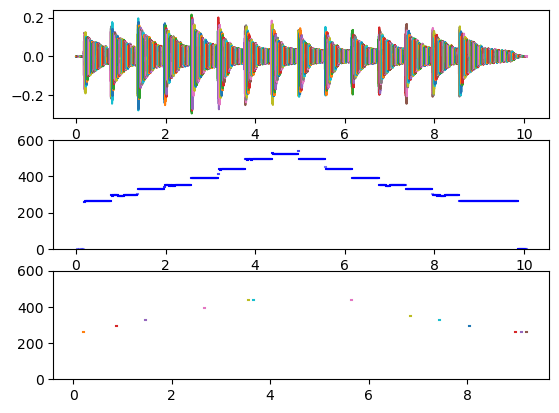

In [53]:
f, ax = plt.subplots(3)

total_read = 0
with aubio.source(WAV_C_MAJOR) as src:
    duration_s = src.duration / src.samplerate
    print("duration: %f seconds (%d samples)" % (
            duration_s,
            src.duration))

    pitch_o = aubio.pitch(
        "yinfast",
        buf_size=2*src.hop_size,
        hop_size=src.hop_size,
        samplerate=src.samplerate)
    
    notes_o = aubio.notes(
        "default",
        buf_size=2 * src.hop_size,
        hop_size=src.hop_size,
        samplerate=src.samplerate)

    for samples in src:
        t0 = total_read / src.samplerate
        n_samples = samples.shape[-1]
        total_read += n_samples
        t1 = total_read / src.samplerate

        if n_samples < src.hop_size:
            break

        pitch = pitch_o(samples)
        assert(pitch.shape == (1,))
        conf = pitch_o.get_confidence()

        note = notes_o(samples)

        print("%.3f" % t1, samples.shape, conf)

        t_vec = np.linspace(t0, t1, n_samples)
        ax[0].plot(t_vec, samples)
        ax[1].plot([t0, t1], [pitch[0], pitch[0]], c='blue', alpha=conf)
        ax[1].set_ylim(0, 600)

        if note[0] > 0:
            note = miditofreq(note[0])
            ax[2].plot([t0, t1], [note, note])
        ax[2].set_ylim(0, 600)

In [36]:
help(aubio.pitch)

Help on class pitch in module aubio:

class pitch(builtins.object)
 |  pitch(method="default", buf_size=1024, hop_size=512, samplerate=44100)
 |  
 |  Pitch detection.
 |  
 |  Supported methods: `yinfft`, `yin`, `yinfast`, `fcomb`, `mcomb`,
 |  `schmitt`, `specacf`, `default` (`yinfft`).
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_confidence(...)
 |  
 |  get_silence(...)
 |  
 |  get_tolerance(...)
 |  
 |  set_silence(...)
 |  
 |  set_tolerance(...)
 |  
 |  set_unit(...)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 